Training with SGD optimizer...
Epoch [20/100], Loss: 0.4924
Epoch [40/100], Loss: 0.4606
Epoch [60/100], Loss: 0.4593
Epoch [80/100], Loss: 0.4618
Epoch [100/100], Loss: 0.4379


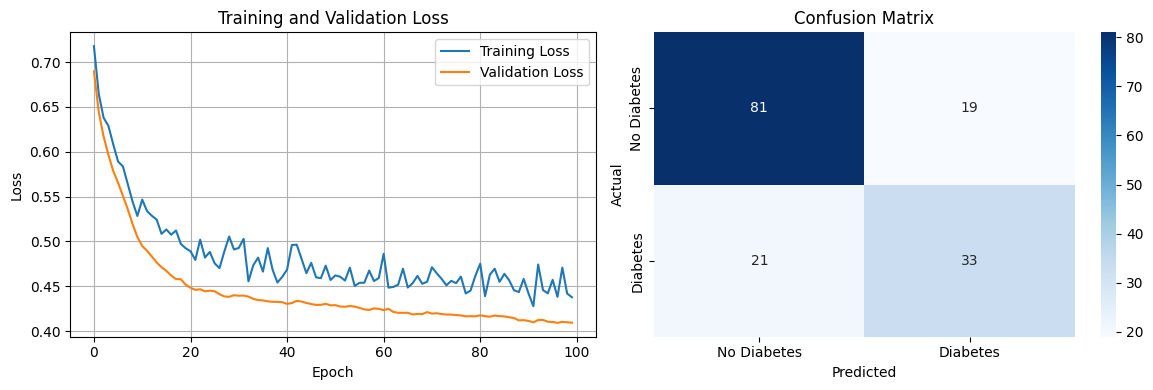


EVALUATION REPORT
Test Loss: 0.4921
Test Accuracy: 0.7403

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.79      0.81      0.80       100
    Diabetes       0.63      0.61      0.62        54

    accuracy                           0.74       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.74      0.74      0.74       154



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# 1. Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
           'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

try:
    data = pd.read_csv(url, header=None, names=columns)
except:
    # Create synthetic data if loading fails
    n = 768
    data = pd.DataFrame({
        'Pregnancies': np.random.randint(0, 17, n),
        'Glucose': np.random.normal(120, 30, n),
        'BloodPressure': np.random.normal(70, 15, n),
        'SkinThickness': np.random.normal(20, 10, n),
        'Insulin': np.random.normal(80, 60, n),
        'BMI': np.random.normal(32, 7, n),
        'DiabetesPedigreeFunction': np.random.uniform(0.1, 2.5, n),
        'Age': np.random.randint(21, 81, n),
        'Outcome': np.random.choice([0, 1], n, p=[0.65, 0.35])
    })

# 2. Preprocess data
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 3. Build model
class DiabetesNet(nn.Module):
    def __init__(self):
        super(DiabetesNet, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(16, 8)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

model = DiabetesNet()

# 4. Setup loss and SGD optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 5. Train model
print("Training with SGD optimizer...")
train_losses = []
val_losses = []

for epoch in range(100):
    # Training
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_train)
        val_loss = criterion(val_outputs, y_train)

    train_losses.append(epoch_loss/len(train_loader))
    val_losses.append(val_loss.item())

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {epoch_loss/len(train_loader):.4f}')

# 6. Evaluate and predict
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test)
    test_loss = criterion(y_pred_proba, y_test)
    y_pred = (y_pred_proba > 0.5).float()
    test_acc = (y_pred == y_test).float().mean()

y_pred_np = y_pred.numpy()
y_test_np = y_test.numpy()

# 7. Visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
axes[0].plot(train_losses, label='Training Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_np)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
axes[1].set_title('Confusion Matrix')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# 8. Evaluation Report
print("\n" + "="*50)
print("EVALUATION REPORT")
print("="*50)
print(f"Test Loss: {test_loss.item():.4f}")
print(f"Test Accuracy: {test_acc.item():.4f}")
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_np, target_names=['No Diabetes', 'Diabetes']))
print("="*50)